# PRE-EDA: DATA LOADING
----

In [1]:
# Data reading and visualization
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

# Statistical analysis
from scipy.stats import norm

# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# XGBoost & LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Remove unwanted warnings from outputs
import warnings
warnings.filterwarnings('ignore')

# Set themes
sns.set_style('darkgrid')
plt.style.use('seaborn-bright')

## CONFIGS
---

In [2]:
BASE_PATH = "./"

rf_params = {
    'n_estimators': 100,
    'max_depth': 2,
    'min_samples_split': 2,
    'min_samples_leaf': 1
    }

xgb_params = {
    'n_estimators': 500,
    'max_depth': 3,
    'min_child_weight': 2,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'booster': 'gbtree'
    }

lgb_params = {
    'n_estimators': 500,
    'max_depth': 3,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'regression'
    }


### HELPER FUNCTIONS
---

In [3]:
# Print dataset usage stats
def print_info(df):
    print(f"\nDataframe Shape: {df.shape}")
    print(f"\nDataframe Columns: {df.columns}")
    print(f"\nDataframe dtypes: \n{df.dtypes.value_counts()}")
    print(
        f"\nDataframe memory usage: {round(df.memory_usage().sum() / 1024**2, 2)} MB")

# Visualize misssing data
def visualize_missing_data(df):
    m_data = (df.isnull().sum() / len(df)) * 100
    m_data = m_data.drop(m_data[m_data == 0].index).sort_values()
    m_data = m_data.rename({'index': 'Feature', 0: 'Missing (%)'})

    fig = px.bar(x=m_data.index, y=m_data,
                 title='Missing Data by Feature', template='plotly_dark')
    fig.update_xaxes(title_text="Feature")
    fig.update_yaxes(title_text="Missing (%)")

    fig.show("png") # Uncomment for interactive plots


# Plot Histogram of dataset
def plot_histogram(df, distline=True):
    if distline:
        fig = plt.figure(figsize=(15, 15))
        for i, column in enumerate(df.columns):
            plt.subplot(4, 4, i+1)
            plt.title(column)
            plt.xlabel(column)
            sns.distplot(df[column], fit=norm)
        plt.tight_layout()
        plt.show()

    if not distline:
        fig = plt.figure(figsize=(15, 15))
        hist = df.hist(figsize=(15, 15), bins=50)
        plt.tight_layout()
        plt.show()

    plt.tight_layout()
    plt.show()

# Fit data to model(s)
def fit_robust_pipeline(model, X_train, y_train, X_test, y_test):
    pipe = Pipeline([('scaler', RobustScaler()), ('model', model)])
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)

    return round(score, 2)

# Scaling Data
def scale_data(scaler, df, feats_to_transform):
    scaled_df = df.copy()
    features = scaled_df[feats_to_transform]
    features = scaler.fit_transform(features.values)

    scaled_df[feats_to_transform] = features

    return scaled_df

# Encode Data
def encode_data(df, encoder_type, feats_to_encode):
    if encoder_type == 'Label':
        for feat in cat_feats:
            label_enc = LabelEncoder()
            label_enc_df[feat] = label_enc.fit_transform(label_enc_df[feat])

        return label_enc_df

    elif encoder_type == 'OneHot':
        for feat in cat_feats:
            onehot_enc = OneHotEncoder(handle_unknown='ignore')
            transformed = pd.DataFrame(onehot_enc.fit_transform(onehot_enc_df[feat].values.reshape(-1, 1)).toarray())
            transformed.columns = [f"{feat}_{i}" for i in transformed.columns]
            onehot_enc_df = onehot_enc_df.join(transformed)
            onehot_enc_df.drop([feat], axis=1, inplace=True)
        
        return onehot_enc_df
    else:
        print("Invalid Encoder Type")

# Fit data to model(s)
def evaluate_performance(X, Y, test_size=0.2, scale_data=False, scaler=None, feats_to_transform=None):
    # Define models
    rf = RandomForestRegressor(**rf_params)
    xgb = XGBRegressor(**xgb_params)
    lgb = LGBMRegressor(**lgb_params)

    # Transform data
    if scale_data:
        X = scale_data(scaler, X, feats_to_transform)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)  

    # Pass models to pipeline
    rf_score = fit_robust_pipeline(rf, X_train, y_train, X_test, y_test)
    xgb_score = fit_robust_pipeline(xgb, X_train, y_train, X_test, y_test)
    lgb_score = fit_robust_pipeline(lgb, X_train, y_train, X_test, y_test)

    # Print scores
    print(f"Model Scores: \n{'-'*25}\n")
    print(f"RandomForestRegressor Score: {rf_score}")
    print(f"XGBRegressor Score: {xgb_score}")
    print(f"LGBMRegressor Score: {lgb_score}")

    return rf, xgb, lgb

# Plot feature importance
def plot_feature_importance(features, title, model):
    fig = px.bar(y=features, x=model.feature_importances_, template='plotly_dark')
    fig.update_layout(title=f"{title}")
    fig.update_xaxes(title_text="Feature Importance")
    fig.update_yaxes(title_text="Feature")

    fig.show("png") # Uncomment for interactive plots

# EXPLORATORY DATA ANALYSIS (EDA)
----

In [4]:
# Read data
df = pd.read_csv(os.path.join(BASE_PATH, "dataset/train.csv"))

In [5]:
# Check shape of dataset
print_info(df)


Dataframe Shape: (1460, 81)

Dataframe Columns: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea

In [6]:
# Tabular representation of statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


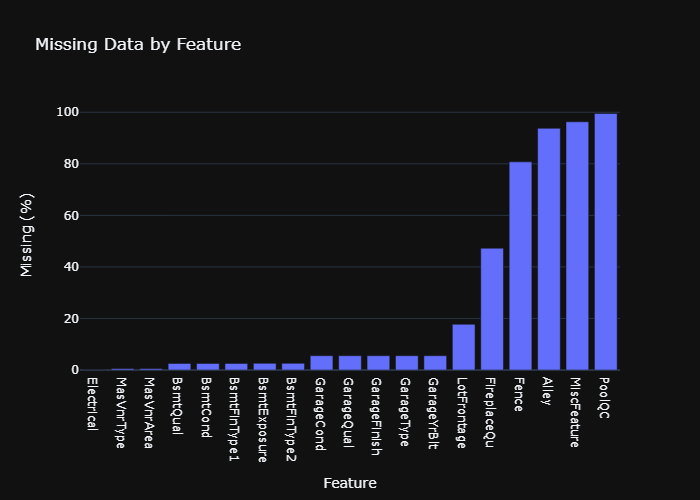

In [7]:
# Check for null values
visualize_missing_data(df)

* Some columns have a lot of missing data, we will either drop them or fill them with the mean value of the column
* To keep things simple, we will only work with numerical data for now

In [8]:
# Filter and keep only the numerical data
df_num = df.select_dtypes(include=['float64', 'int64'])

# Filter out more catgeorical and time-series data given in `data_description.txt`
to_drop = ['Id', 'MSSubClass', 'OverallQual', 'OverallCond', 'YearRemodAdd','MoSold', 'YrSold',  'FullBath', 'HalfBath', 'Fireplaces', 'GarageCars']
df_num.drop(to_drop, axis=1, inplace=True)

# Even more filtering to remove miscellanous features
to_drop = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'MiscVal', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
df_num.drop(to_drop, axis=1, inplace=True)

# Check shape of dataset
print_info(df_num)



Dataframe Shape: (1460, 15)

Dataframe Columns: Index(['LotFrontage', 'LotArea', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea', 'SalePrice'],
      dtype='object')

Dataframe dtypes: 
int64      14
float64     1
dtype: int64

Dataframe memory usage: 0.17 MB


## VISUALIZATION(S)!!!
---

- Although bivariate and single variable analyses are possible by plotting each feature or one against another, doing so one by one takes a significant amount of time, especially if we wish to tackle all possible permutations. 


- As a data analyst, this is most likely the path you would choose, but as a Machine Learning Engineer, your goal is to get through the data as fast as possible. 


- We will first take a look at some examples of doing it the data-analyst way, and then proceed to do the same, but much faster

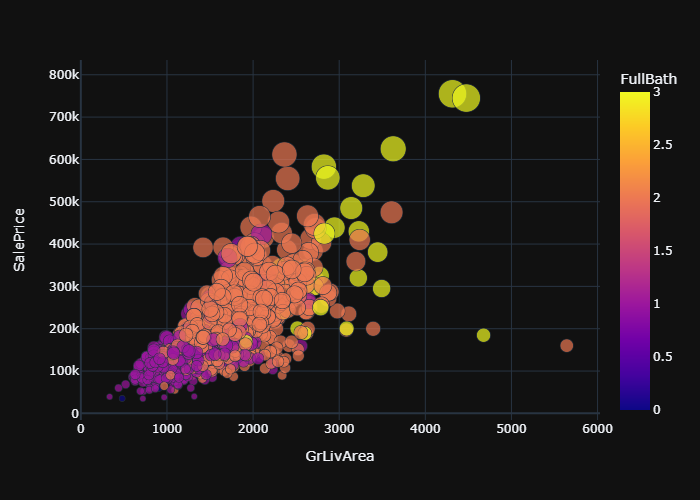

In [9]:
# Analyse how living area affects the saleprice, using a color gradient and sized scatter-dots
# The plotly library allows us to interact with our plots, feel free to hover over the data to see popups with guiding information
# You can also cut out sections of the plot to analyze only those ranges you wish to

fig = px.scatter(df, 'GrLivArea', 'SalePrice', size='SalePrice', color='FullBath', template='plotly_dark')
fig.show("png") # Uncomment for interactive plots

# Note: If you are viewing these plots on github (i.e, in the browser), they will not have any interactive capabilities due to plotly's embedded javascript. Also, the plots may appear 'squished' or 'squeezed'

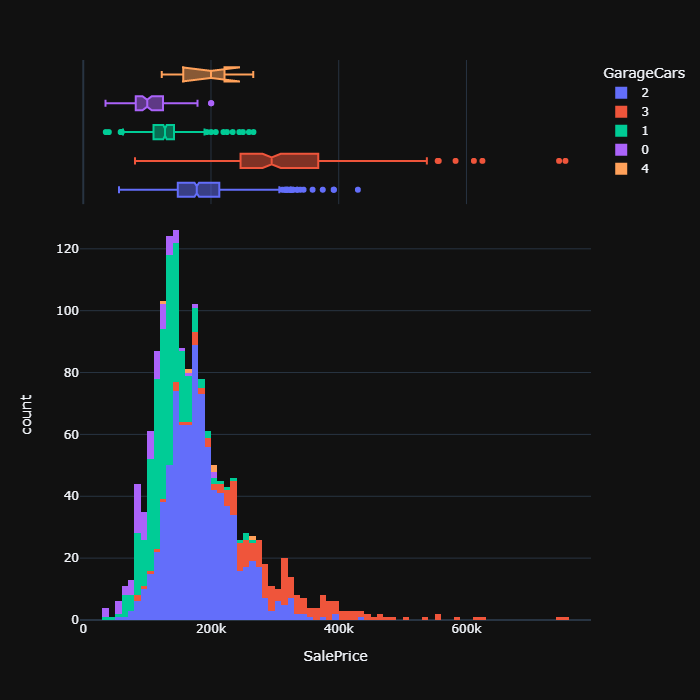

In [10]:
# Analyze distribution of sale price
# Again, plotly gives us the ability to interact with our plots. 
# Hover over the box plots to get an easier view of the plot-data
fig = px.histogram(df, 'SalePrice', color='GarageCars', marginal='box', template='plotly_dark', height=700)
fig.show("png") # Uncomment for interactive plots

- Although these plots are pleasing to the eye, and easier to work with (interactive!), it can take forever to analyze the preprocess the data if there are hundreds of features. To speed things up, we can use subplots, or multiple plots generated by the seaborn library, all in the same window.
- We will first start with analyzing distributions (single variable analysis) and then move on to observing trends and relationships between our features (bi/multi-variate analysis )

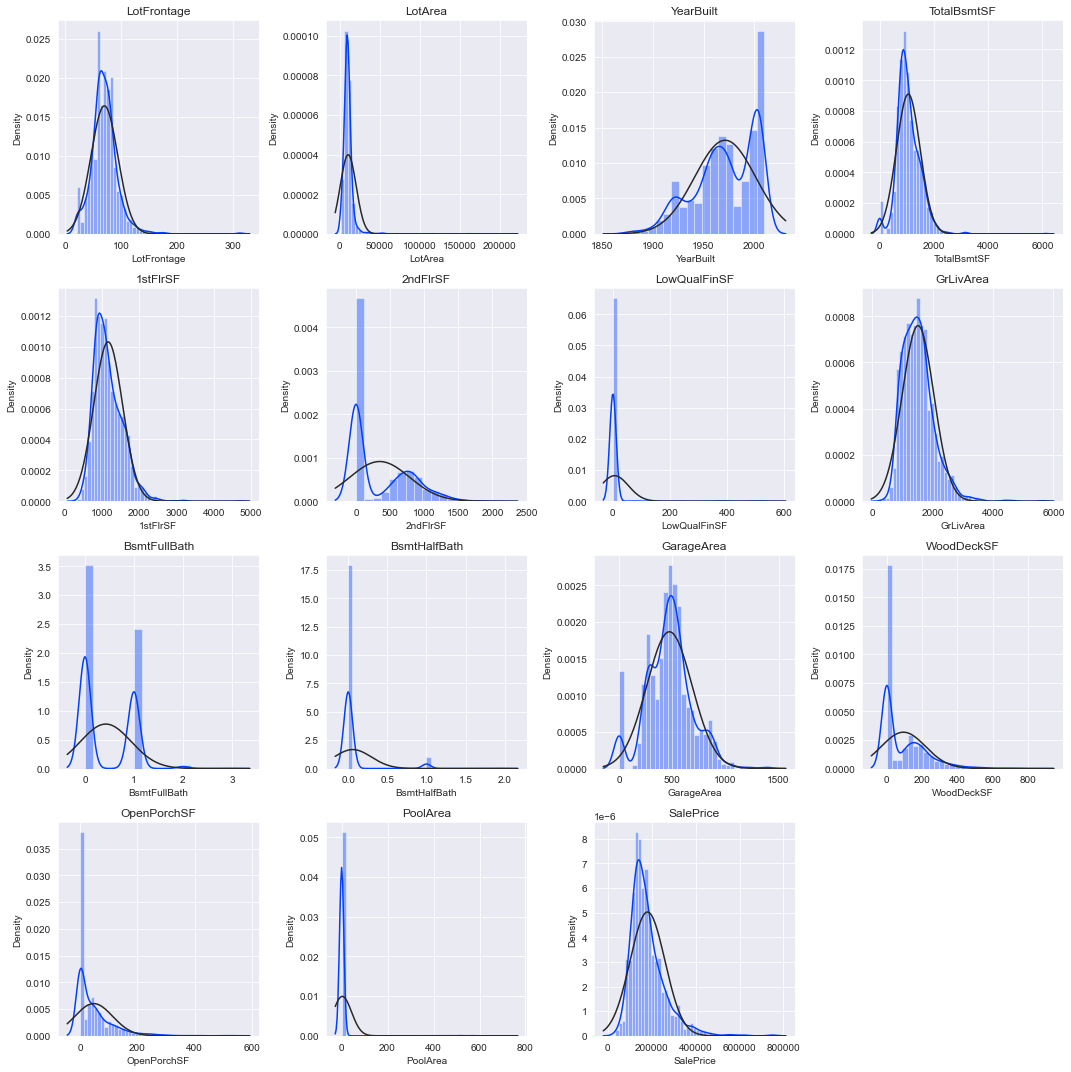

<Figure size 432x288 with 0 Axes>

In [11]:
# Observe each feature's distribution
# The blue line is the data's distribution
# The black line is what the the 'ideal' or 'normal' distribution for the data would be, if the data is somehow manipulated
plot_histogram(df_num, distline=True)

In [12]:
# There are a couple of features which remain constant. Let's remove them.
df_num.drop(['LowQualFinSF', 'PoolArea'], axis=1, inplace=True)

<Figure size 1800x720 with 0 Axes>

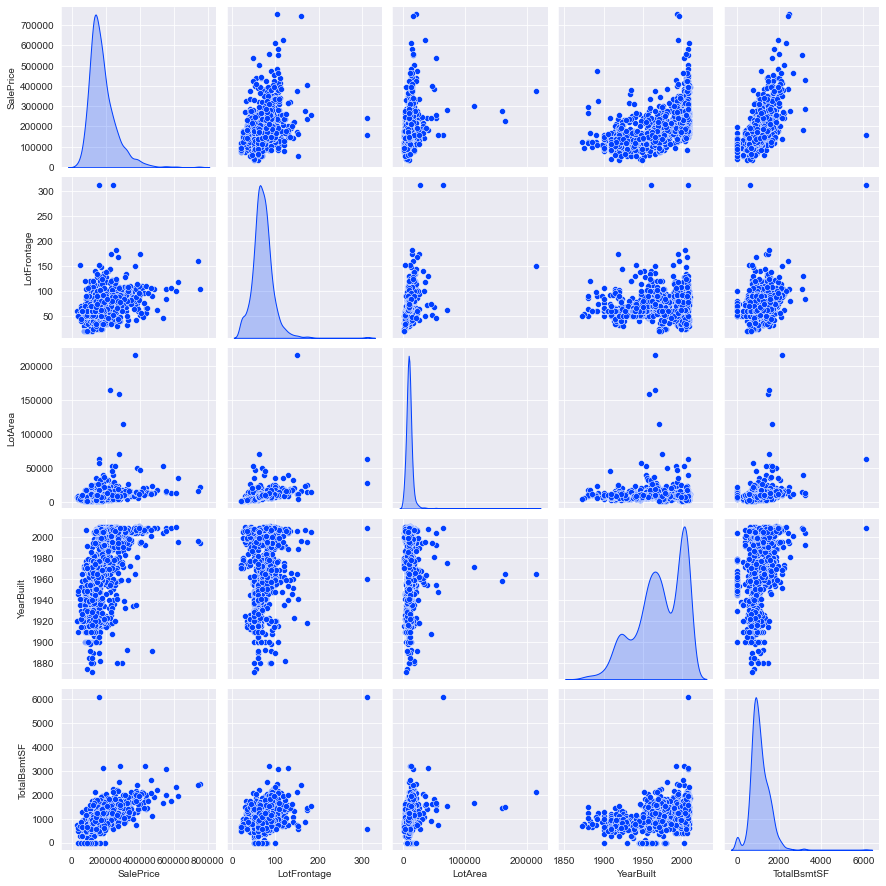

In [13]:
# Use pairplots to see how one feature is related to the other
features = list(df_num.columns)
features.remove('SalePrice')

# Since these can get very large, let's use only the SalePrice and the first 4 features
fig = plt.figure(figsize=(25, 10))
viz_df = pd.concat([df_num['SalePrice'], df_num[features[:4]]], axis=1)
# sns.pairplot(viz_df, diag_kind='kde', hue='SalePrice', height=2.5)

sns.pairplot(viz_df, diag_kind='kde', height=2.5)
plt.show()


<Figure size 1800x720 with 0 Axes>

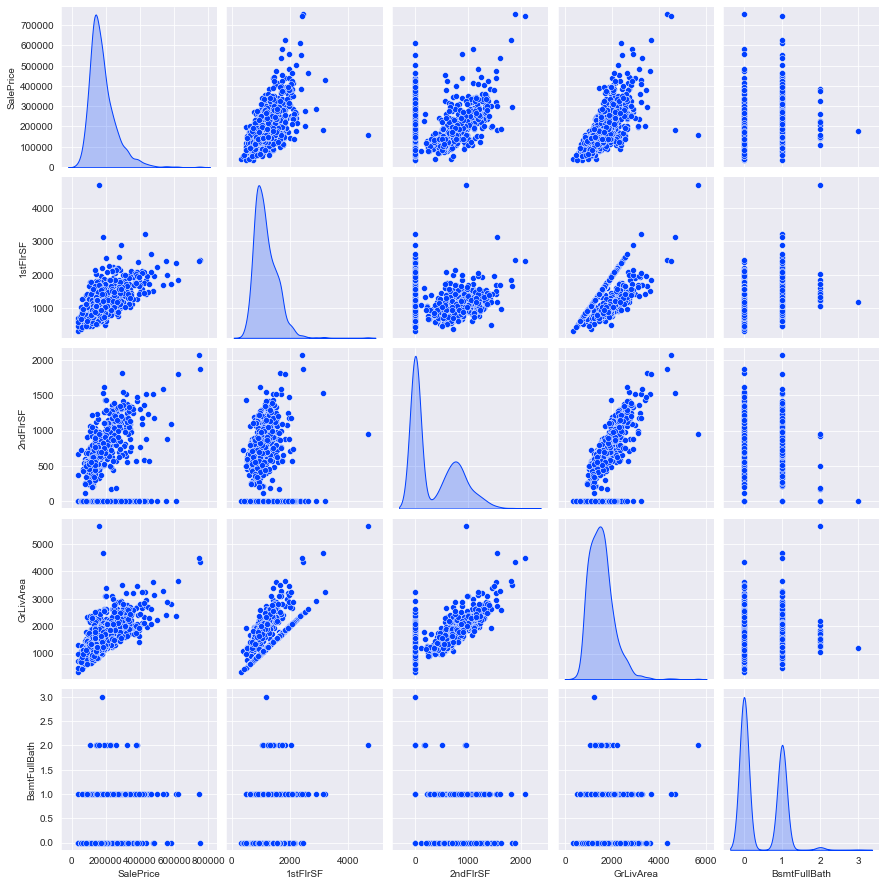

In [14]:
# Since these can get very large, let's use only the SalePrice and the second 4 features
fig = plt.figure(figsize=(25, 10))
viz_df = pd.concat([df_num['SalePrice'], df_num[features[4:8]]], axis=1)
# sns.pairplot(viz_df, diag_kind='kde', hue='SalePrice', height=2.5)
sns.pairplot(viz_df, diag_kind='kde', height=2.5)
plt.show()

<Figure size 1800x720 with 0 Axes>

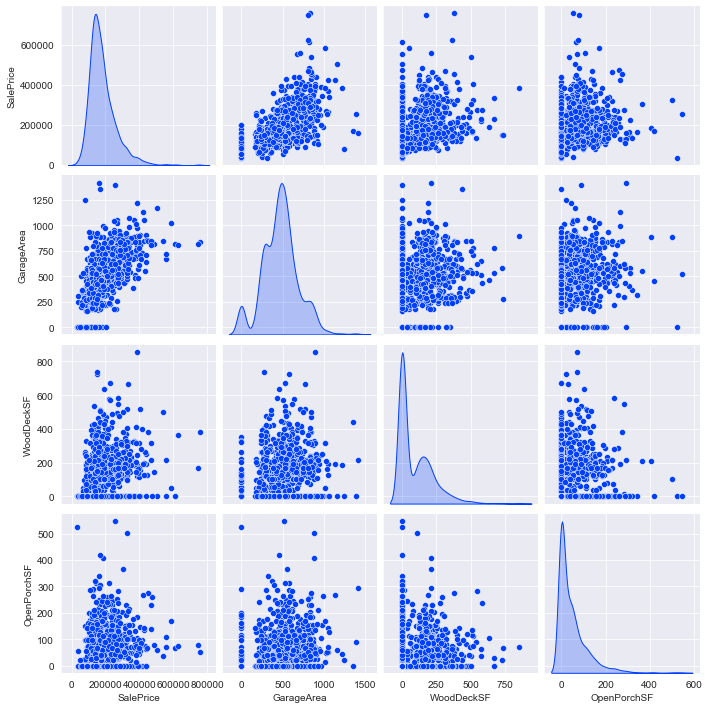

In [15]:
# Since these can get very large, let's use only the SalePrice and the last 3 features
fig = plt.figure(figsize=(25, 10))
viz_df = pd.concat([df_num['SalePrice'], df_num[features[9:]]], axis=1)
# sns.pairplot(viz_df, diag_kind='kde', hue='SalePrice', height=2.5)
sns.pairplot(viz_df, diag_kind='kde', height=2.5)
plt.show()


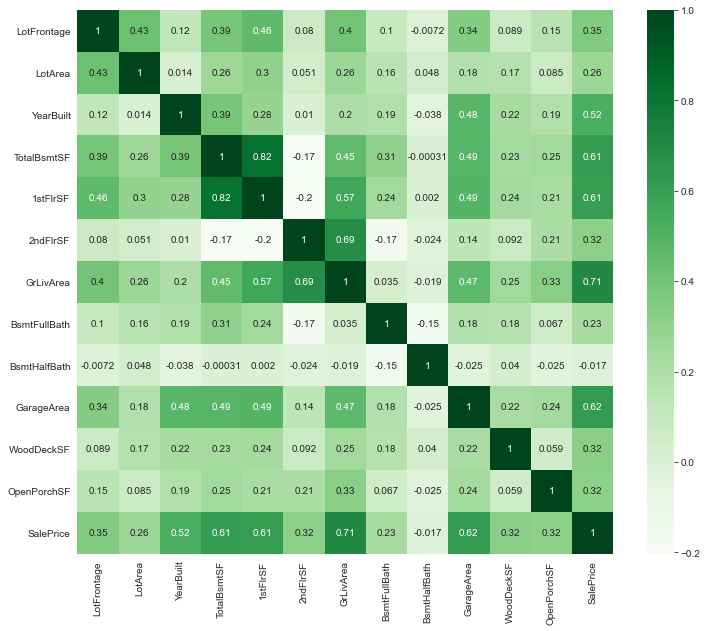

In [16]:
# Correlation Matrix
fig = plt.figure(figsize=(12, 10))
sns.heatmap(df_num.corr(), cmap='Greens', annot=True)
plt.show()

- If pairplots appear challenging, you can use a correlation heatmap (although you will be unable to identify outliers) to see to what extent one variable affects another.

- Since our target variable is `SalePrice`, we should be concerned about what features seem to be the most impactful.
- The features with the highest correlation to our target variable will be the features our models find most important.
- We will later on plot our model's `feature importances` or the features that our model found most helpful and test our hypothesis.

# FEATURE GENERATION
----

In [17]:
# Now that we are done with cleaning the data, let's try to generate more features 
# by using the existing ones.

pre_gen_feats = df_num.columns.values.tolist()
print(pre_gen_feats)

# For example, We can combine the 'LotArea', 'TotalBsmtSF', 'GarageArea', 'WoodDeckSF', OpenPorchSF' features to generate a new feature: 'ExtArea'
df_num['ExtArea'] = df_num['LotArea'] + df_num['TotalBsmtSF'] + df_num['GarageArea'] + df_num['WoodDeckSF'] + df_num['OpenPorchSF']

# Another example, combine all bathrooms in basement
df_num['AllBsmtBaths'] = df_num['BsmtFullBath'] + 0.5*df_num['BsmtHalfBath']

['LotFrontage', 'LotArea', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']


# DATA PREPROCESSING
----

In [18]:
# We now need to make sure that the data has a normal distribution.

# To achieve this, we can use(among many options):
#     - StandardScaler: Regular normalization, where transformed_x = (x-column_mean)/column_std_deviation
#     - MinMaxScaler: Scales data between 0 and 1 (by default, but can be scaled between any two values of your choice)

In [19]:
# First. let's convert the categorical features to strings

df_num['BsmtFullBath'] = df_num['BsmtFullBath'].astype('str')
df_num['BsmtHalfBath'] = df_num['BsmtHalfBath'].astype('str')
df_num['AllBsmtBaths'] = df_num['AllBsmtBaths'].astype('str')

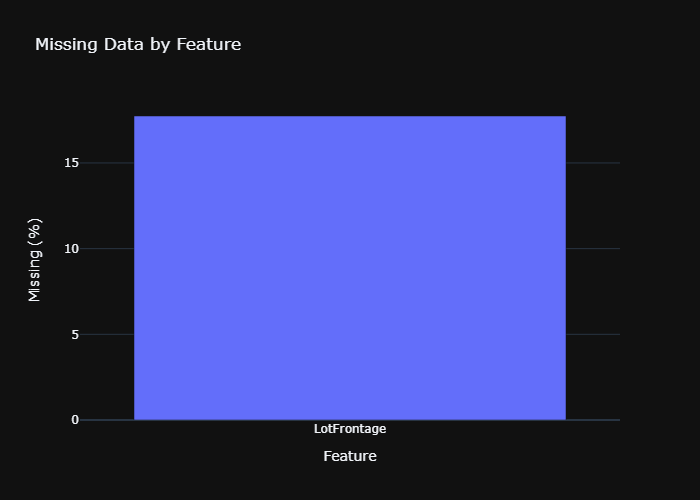

In [20]:
# Next, let's work with the missing values 

visualize_missing_data(df_num)

In [21]:
# Since LotFrontage has a lot of missing values, we can:
# 1. Use `impute`:
#     - impute max/min value into missing areas
#     - impute mean/median/mode value into missing areas
# 2. drop the rows with the missing values
# 3. drop the whole column

# We will use option 1 as our dataset is relatively small, and losing data will not be beneficial

In [22]:
# Impute the mean value of the column in the missing value areas

df_num['LotFrontage'].fillna(df_num['LotFrontage'].mean(), inplace=True)

In [23]:
# Next, we deal with outliers
# For this, we go back to the pairplots!

# In GrLivArea vs SalePrice --> we have outliers 
# It doesn't make sense to have a house of nearly 6000sqft listed for a mere 200k dollars
# Although modern gradient boosting machines are built to automatically tacke these problems, models like LinearRegression are highly prone to reduced accuracy due to outliers (Unless we use different scalers such as RobustScaler and so on...)
df_num = df_num.loc[(df_num['GrLivArea'] < 4000) & (df_num['SalePrice'] < 300000)]

# There are several more outliers in the dataset, but we will not be going through them.

In [24]:
# Encode the Categorical Data
cat_feats = df_num.select_dtypes('object').columns.values.tolist()

label_enc_df, onehot_enc_df = df_num.copy(), df_num.copy()

# LabelEncoding
for feat in cat_feats:
    label_enc = LabelEncoder()
    label_enc_df[feat] = label_enc.fit_transform(label_enc_df[feat])

# OneHotEncoding
for feat in cat_feats:
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    transformed = pd.DataFrame(onehot_enc.fit_transform(onehot_enc_df[feat].values.reshape(-1, 1)).toarray())
    transformed.columns = [f"{feat}_{i}" for i in transformed.columns]
    onehot_enc_df = onehot_enc_df.join(transformed)
    onehot_enc_df.drop([feat], axis=1, inplace=True)


# NORMALIZATION 
----

In [25]:
# We first need to split the data into train and test sets
label_X, label_Y = label_enc_df.drop('SalePrice', axis=1), label_enc_df['SalePrice']
onehot_X, onehot_Y = onehot_enc_df.drop('SalePrice', axis=1), onehot_enc_df['SalePrice']

In [26]:
# First, let's test see how our models perform without any scaling
rf, xgb, lgb = evaluate_performance(label_X, label_Y, test_size=0.2)

Model Scores: 
-------------------------

RandomForestRegressor Score: 0.67
XGBRegressor Score: 0.8
LGBMRegressor Score: 0.8


In [27]:
# List all features we wish to transform
feats_to_transform = ['LotFrontage', 'LotArea', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF',
                      '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'ExtArea']

In [28]:
# Apply StandardScaler
scaler = StandardScaler()
standard_label_X = label_X.copy()
standard_label_X = scale_data(scaler, standard_label_X, feats_to_transform)

# Visualize scaled data
# plot_histogram(scaled_label_X, distline=False)

# Test model performance on new data
standardsc_rf, standardsc_xgb, standardsc_lgb = evaluate_performance(standard_label_X, label_Y, test_size=0.2)


Model Scores: 
-------------------------

RandomForestRegressor Score: 0.59
XGBRegressor Score: 0.79
LGBMRegressor Score: 0.78


In [29]:
# Apply StandardScaler
scaler = MinMaxScaler()
minmax_label_X = label_X.copy()
minmax_label_X = scale_data(scaler, minmax_label_X, feats_to_transform)

# Visualize scaled data
# plot_histogram(minmax_label_X)

# Test model performance on new data
minmaxsc_rf, minmaxsc_xgb, minmaxsc_lgb = evaluate_performance(minmax_label_X, label_Y, test_size=0.2)


Model Scores: 
-------------------------

RandomForestRegressor Score: 0.6
XGBRegressor Score: 0.82
LGBMRegressor Score: 0.81


# FEATURE SELECTION
----

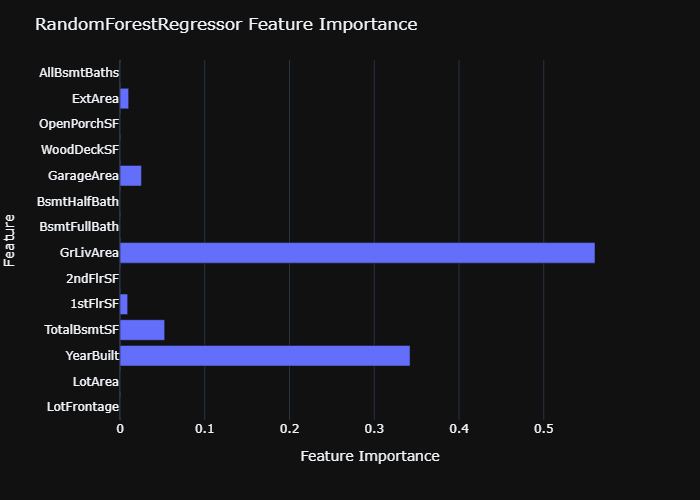

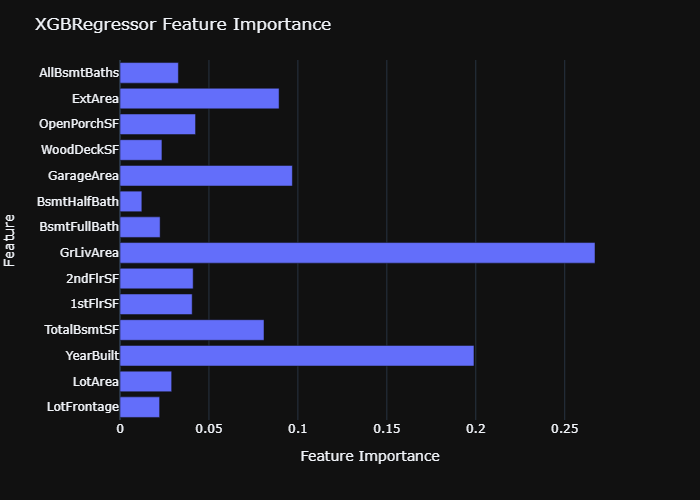

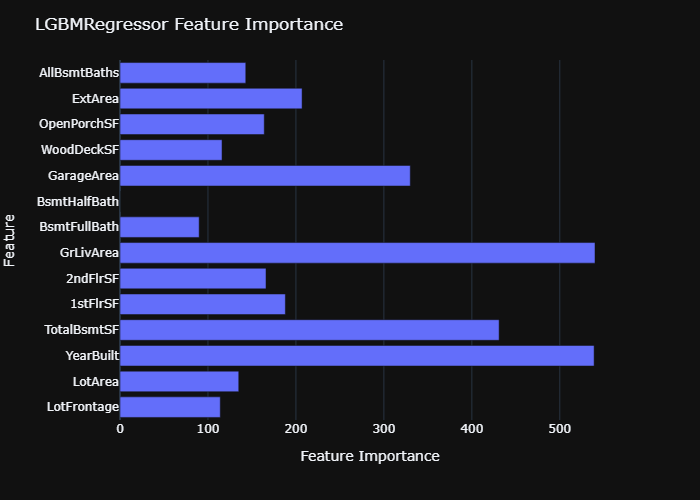

In [30]:
# Let's see which of the features are the most important by each model

# StandardScaler Model

# RandomForestRegressor
plot_feature_importance(minmax_label_X.columns, "RandomForestRegressor Feature Importance", standardsc_rf)
# XGBRegressor
plot_feature_importance(minmax_label_X.columns, "XGBRegressor Feature Importance", standardsc_xgb)
# LGBMRegressor
plot_feature_importance(minmax_label_X.columns, "LGBMRegressor Feature Importance", standardsc_lgb)

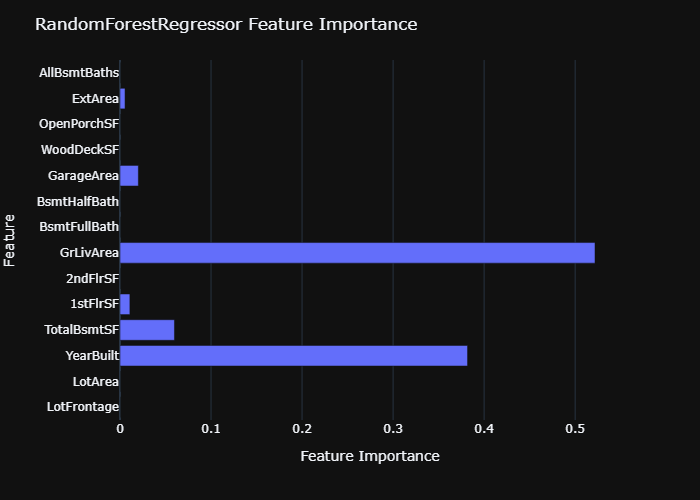

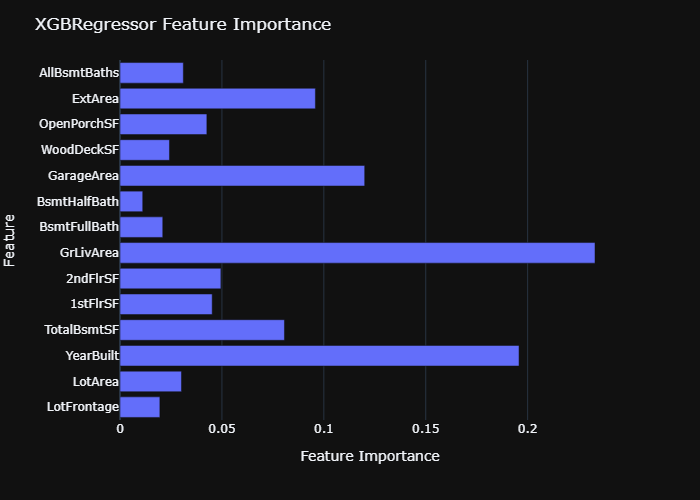

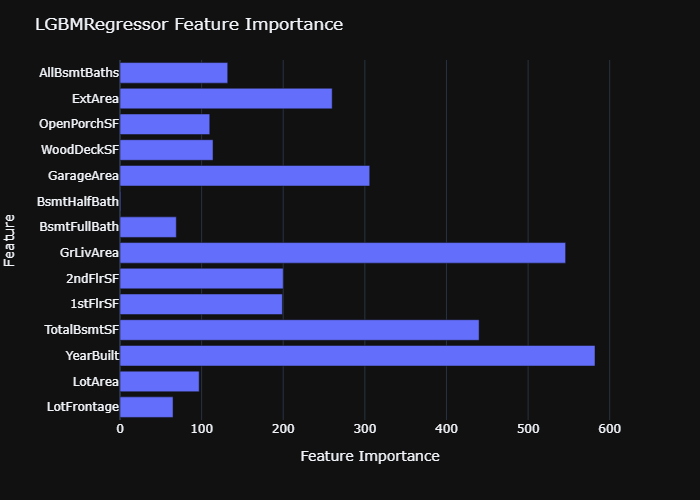

In [31]:
# Let's see which of the features are the most important by each model

# MinMaxScaler Model

# RandomForestRegressor
plot_feature_importance(minmax_label_X.columns, "RandomForestRegressor Feature Importance", minmaxsc_rf)
# XGBRegressor
plot_feature_importance(minmax_label_X.columns, "XGBRegressor Feature Importance", minmaxsc_xgb)
# LGBMRegressor
plot_feature_importance(minmax_label_X.columns, "LGBMRegressor Feature Importance", minmaxsc_lgb)


# Aaaand.... We're Done! Good Luck Ahead!